In [10]:
#if alreasy installed, don't need to run following codes
#!conda update conda
#!conda config --add channels conda-forge
#!conda install spacy -y
#!python -m spacy download en

#!conda install scikit-learn -y
#!conda install beautifulsoup4 -y
#!conda install elasticsearch -y
#!pip install pyLDAvis

#for error ModuleNotFoundError: No module named 'cycler' when import matplotlib
#remember restart this notebook or using importlib.reload
#!conda remove matplotlib -y
#!conda remove cycler -y
#!pip uninstall cycler -y
#!pip uninstall matplotlib -y
#!pip install cycler
#!pip install matplotlib
!pip install memory_profiler

You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
from sklearn.model_selection import train_test_split
import time

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]
  
from Models import DataLoadModel
from Utils import utilTools,utilDataPreprocess,utilLDA
import importlib
importlib.reload(DataLoadModel)
importlib.reload(utilTools)
importlib.reload(utilLDA)
importlib.reload(utilDataPreprocess)

IDFILE="./idlist_cleaned.pkl"
DATAFILE_CLEANED="./preprocessed_data_cleaned.pkl"
DATAFILE_VECTORIZED="./preprocessed_data_vectorized.pkl"
VECTORIZERFILE = "./vectorizer.pkl"

D:\Program_Files\Anaconda3\lib\site-packages\_pytest\fixtures.py:834: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))
D:\Program_Files\Anaconda3\lib\site-packages\_pytest\fixtures.py:836: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  ids = attr.ib(default=None, convert=_ensure_immutable_ids)
D:\Program_Files\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
D:\Program_Files\Anaconda3\lib\site-packages\msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
D:\Program_Files\Anaconda3\li

D:\Program_Files\Anaconda3\lib\site-packages\msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
D:\Program_Files\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
D:\Program_Files\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
D:\Program_Files\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
D:\Program_Files\Anaconda3\l

D:\Program_Files\Anaconda3\lib\site-packages\msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
D:\Program_Files\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
D:\Program_Files\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
D:\Program_Files\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
D:\Program_Files\Anaconda3\l

D:\Program_Files\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
D:\Program_Files\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
D:\Program_Files\Anaconda3\lib\site-packages\msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
D:\Program_Files\Anaconda3\lib\site-packages\msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
D:\Program_Files\Anaconda3\l

In [2]:
def saveCleanedData(idlist, data):
    if idlist is None or data is None:
         raise ValueError('you must input two valid objects')
    try:
        utilTools.pickleDump(IDFILE, idlist)
        utilTools.pickleDump(DATAFILE_CLEANED, data)
    except Exception as e:
        print(e)
        print("save failed, idfile={}, dataFile={}".format(IDFILE, DATAFILE_CLEANED))
        raise e
        
def loadCleanedData():
    try:
        idlist = utilTools.pickleLoad(IDFILE)
        data = utilTools.pickleLoad(DATAFILE_CLEANED)
    except Exception as e:
        print(e)
        print("load failed, idfile={}, dataFile={}".format(IDFILE, DATAFILE_CLEANED))
        raise e
        
    return idlist, data   

In [3]:
def saveVectorizedData(data, vectorizer):
    if idlist is None or data is None or vectorizer is None:
         raise ValueError('you must input two valid objects')
    try:
        utilTools.pickleDump(DATAFILE_VECTORIZED, data)
        utilTools.pickleDump(VECTORIZERFILE, vectorizer)
    except Exception as e:
        print(e)
        print("save failed,dataFile={}, vectorizerFile={}".format(DATAFILE_VECTORIZED, VECTORIZERFILE))
        raise e
        
def loadVectorizedData():
    try:
        data = utilTools.pickleLoad(DATAFILE_VECTORIZED)
        vetorizer = utilTools.pickleLoad(VECTORIZERFILE)
    except Exception as e:
        print(e)
        print("load failed, dataFile={}, vectorizerFile={}".format(DATAFILE_VECTORIZED, VECTORIZERFILE))
        raise e
        
    return data, vectorizer  

In [4]:
#Parse XML [/home1/irteam/lhy_tmp/p7zip_16.02/bin/Posts.xml]Done, total [14995834] records!
#Retrieved 14995834 records in 1708.5482077598572 Seconds
#clean data in 12500.394113063812 Seconds

def loadAndCleanData(n_jobs=1, force_reload=False, force_reload_file=None, force_reload_count=-1):
    try:
        if force_reload:
            raise ValueError("will force reload data...")
        start_time = time.time()
        idlist, data = loadCleanedData()
        end_time = time.time()
        print("load {} preprocessed cleaned records in {} Seconds".format(len(idlist), end_time - start_time))
    except Exception as e:
        print("load preprocessed data failed, Will retrieve from dataset...")
        start_time = time.time()
        data = DataLoadModel.loadStackoverflowFromXML(r"F:\stackoverflow.com-Posts\Posts.xml",force_reload_count)
        #Parse XML [/home1/irteam/lhy_tmp/p7zip_16.02/bin/Posts.xml]Done, total [14995834] records!
        #Retrieved 14995834 records in 1578.7807323932648 Seconds
        #data = DataLoadModel.iterLoadStackoverflowFromES(1000)
        end_time = time.time()
        print("Retrieved {} records in {} Seconds".format(len(data), end_time - start_time))
        
        start_time = time.time()
        X_train = [row[1] for row in data]
        idlist = [row[0] for row in data]
        cleaner = utilDataPreprocess.CleanTextTransformer(n_jobs=n_jobs)
        data = cleaner.fit_transform(X_train)
        try:
            saveCleanedData(idlist, data)
            pass
        except Exception as e:
            print(e)
            print("pickleDump cleaned data Failed")
        end_time = time.time()
        print("clean data in {} Seconds".format(end_time - start_time))
        
    return idlist, data

In [5]:
def vectorizData(data, min_df=5, max_df = 0.6, max_features=20000, force_reprocess=False):
    try:
        if force_reprocess:
            raise ValueError("will force reprocess data...")
        start_time = time.time()
        data, vectorizer = loadVectorizedData()
        end_time = time.time()
        print("load {} preprocessed vectorized data in {} Seconds".format(len(data), end_time - start_time))
    except Exception as e:
        print("load preprocessed vectorized data failed, Will reprocess...")
        data, vectorizer = utilDataPreprocess.countvectorizeData(data, min_df, max_df, max_features)
        try:
            saveVectorizedData(data, vectorizer)
        except Exception as e:
            print("pickleDump vectorized data Failed")
        
    return data, vectorizer

Wall time: 0 ns
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 315.59 MiB, increment: 0.12 MiB
load preprocessed data failed, Will retrieve from dataset...
Parse XML [F:\stackoverflow.com-Posts\Posts.xml]Done, total [1001] records!
Retrieved 1001 records in 0.10730433464050293 Seconds
clean data in 3.113132953643799 Seconds
load preprocessed vectorized data failed, Will reprocess...
vectorize done in 25.117146730422974 Seconds
Topic #0:
good code people php interface information java question practice specific email lot web eclipse business resource security common new book
Topic #1:
sub preference session discussion fact open root view welcome basic note help logical end exception bit long explanation folder web.config
Topic #2:
string type list text result instance search array byte item character algorithm node case extension tree space char warning office
Topic #3:
application thread library document framework main .ne

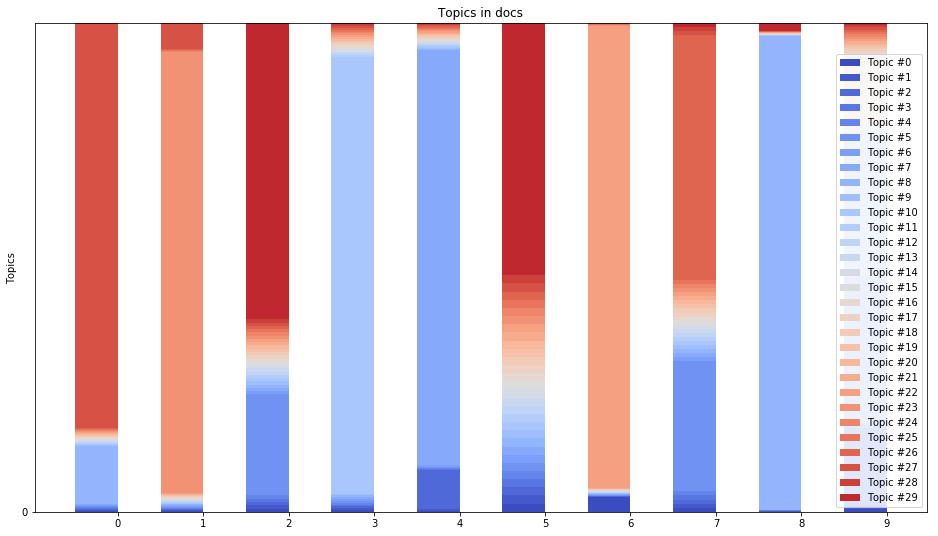

(10, 30)
4
[0.00196078 0.00196078 0.00196078 0.00196078 0.00196078 0.00196078
 0.00196078 0.00196078 0.11960784 0.00196078 0.00196078 0.00196078
 0.00196078 0.00196078 0.00196078 0.00196078 0.00196078 0.00196078
 0.00196078 0.00196078 0.00196078 0.00196078 0.00196078 0.00196078
 0.00196078 0.00196078 0.00196078 0.8254902  0.00196078 0.00196078]


In [7]:
%time
%load_ext memory_profiler
#%mprun
%memit

if __name__ == "__main__":
    
    idlist, cleaned_data = loadAndCleanData(n_jobs=4, force_reload=True, 
                                            force_reload_file=r"F:\stackoverflow.com-Posts\Posts.xml", 
                                            force_reload_count=1000)
    
    vecterized_data, vectorizer = vectorizData(cleaned_data, force_reprocess=True, max_features=10000)
    
    start_time = time.time()
    lda = utilLDA.trainLDA(vecterized_data, n_topics=30)
    feature_names = vectorizer.get_feature_names()
    utilLDA.print_top_words(lda, feature_names, 20)
    end_time = time.time()
    print("Trained LDA in {} Seconds".format(end_time - start_time))
    
    #get document_topic_distribution
    doc_topic_distr = lda.transform(vecterized_data[:10])
    utilLDA.visDocTopicDist(doc_topic_distr)
    print(doc_topic_distr.shape)
    print(idlist[0])
    print(doc_topic_distr[0])
    
    #utilLDA.visLDA(lda, vecterized_data, vectorizer, utilTools.getIP(), 8889)
    #utilLDA.visLDA(lda, X_train_preprocess, vectorizer, "127.0.0.1",8889)